# Homework 7: Fake News Classification

Due: 11:59pm, June 2.

## Please restart the kernel and run all before you submit!

## Your Name: Amay Jain

Throughout the HW, function docstrings, incline comments, and markdown are required. 

## Acquiring data

Read the csv file from the given link 

    train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Regular expression operations
import re  
# built in string module: change uppercase and lowercase
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

# requires update to tensorflow 2.4
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from nltk.corpus import stopwords

2024-05-30 14:15:26.536633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# download dataset

train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
df = pd.read_csv(train_url)

## Make Datasets

Write a function called `make_dataset`. This function should do four things:

1. Change the text to lowercase.

2. Remove stopwords from the article text and title. A stopword is a word that is usually considered to be uninformative, such as “the,” “and,” or “but.” You may find this StackOverFlow thread to be helpful.

3. Construct and return a tf.data.Dataset with two inputs and one output. The input should be of the form (title, text), and the output should consist only of the fake column. You may find it helpful to consult lecture notes or this tutorial for reference on how to construct and use Datasets with multiple inputs.

Helpful resources:
1. Lower case: https://saturncloud.io/blog/how-to-lowercase-a-pandas-dataframe-string-column-if-it-has-missing-values/

2. Remove stopwords: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe. You need to install nltk library. If you do not want to install it, you can use Google colab.

3. Tensorflow dataset with multiple inputs and set batch: https://stackoverflow.com/questions/52582275/tf-data-with-multiple-inputs-outputs-in-keras.

In [3]:
def make_dataset(df):
    '''
    Creates a tidy tensorflow dataset with lowercase text and no stopwords

    Args:
        1) df (pandas dataframe): dataset containing textual features and output labels

    Returns:
        A prepped tensorflow dataset with textual features as inputs and labels as output
    '''

    data = df.copy()

    # change text column to lowercase
    data['text'] = data['text'].str.lower()

    # list of common english stopwords
    stop = stopwords.words('english')

    # remove stopwords from both title and text columns
    data['title'] = data['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    # Convert dataset from pandas to tensorflow format
    data = tf.data.Dataset.from_tensor_slices(
        (
            {
                'title': data[['title']],
                'text': data[['text']]
            },
            {
                'fake': data[['fake']]
            }
        )
    )

    return data

In [4]:
tf_df = make_dataset(df) # convert original dataset

2024-05-30 14:15:54.072930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train test split:

Write a function `train_test_split` to do train test split for any tensorflow dataset. The passing argument should be the training size.


Then, you should use your function to do train_test split and the training size is 80% of your dataset. 

In [5]:
def train_test_split(data, train_size = 0.8):

    '''
    Provides a train and test dataset for any tensorflow dataset

    Args:
        1) data (tensorflow dataset): given dataset
        2) train_size (float): % of dataset needed for training

    Returns:
        Train and test tensorflow datasets
    '''

    # Number of training datapoints
    train_size = int(train_size * len(df))

    # Create train / test data
    train, test = data.take(train_size), data.skip(train_size)
    
    return train, test

In [6]:
# Split data into train and test

train, test = train_test_split(tf_df, 0.8)




# Create validation data - 20% of the train data

val_size = int(0.2 * len(train)) # Number of validation datapoints

train_size = len(train) - val_size # New number of training datapoints after taking out validation data




# Redefine new training data and create validation data

new_train, val = train.take(train_size), train.skip(train_size)




# Batch data to make training model faster

batch_size = 50

train, val, test = new_train.batch(batch_size), val.batch(batch_size), test.batch(batch_size)

## Text vectorization

Here is one option:

    #preparing a text vectorization layer for tf model
    size_vocabulary = 2000

    def standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
        return no_punctuation 

    title_vectorize_layer = TextVectorization(
        standardize=standardization,
        max_tokens=size_vocabulary, # only consider this many words
        output_mode='int',
        output_sequence_length=500) 

    title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))
    
You can also use your preferred vectorization, e.g. text vectorization. You are also welcome to change the parameters such as `size_vocabulary` and `output_sequence_length`. 



In [7]:
# preparing vectorization layers for tf model
size_vocabulary = 2000

def standardization(input_data):
    '''
    Cleans up data by converting text to lowercase and removing punctuation

    Args:
        1) input_data (tensoflow dataset): column of textual data

    Returns:
        Standardized column of text converted to lowercase and no punctuation
    '''

    # Convert text to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove punctuation from text
    no_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation),'')
    
    return no_punctuation 



# vectorization for title column
title_vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = size_vocabulary, # only consider this many words
    output_mode = 'int',
    output_sequence_length = 500) 

# vectorization for text column
text_vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = size_vocabulary, # only consider this many words
    output_mode = 'int',
    output_sequence_length = 500) 



# Adapt training data to vectorization layers

title_vectorize_layer.adapt(train.map(lambda x, y: x['title']))

text_vectorize_layer.adapt(train.map(lambda x, y: x['text']))

## Create Models

Please use Keras models to offer a perspective on the following question:

`When detecting fake news, is it most effective to focus on only the title of the article, the full text of the article, or both?`
To address this question, create three (3) Keras models.

In the first model, you should use only the article title as an input.

In the second model, you should use only the article text as an input.

In the third model, you should use both the article title and the article text as input.

Train your models on the training data until they appear to be “fully” trained. Assess and compare their performance. Make sure to include a visualization of the training histories.


## Notes:

1. For the first two models, you don’t have to create new Datasets. Instead, just specify the inputs to the keras.Model appropriately, and Keras will automatically ignore the unused inputs in the Dataset.

2. The lecture notes and tutorials linked above are likely to be helpful as you are creating your models as well.

3. You will need to use the Functional API, rather than the Sequential API, for this modeling task.

4. When using the Functional API, it is possible to use the same layer in multiple parts of your model; see this [tutorial](https://keras.io/guides/functional_api/) for examples. I recommended that you share a text vectorization layer and an embedding layer for both the article title and text inputs.
    
    Note: Do not use the shared embedding layer with separate text vectorization layers. If you do so, you will be embedding two different words on the same coordinate.

5. You may encounter overfitting, in which case Dropout layers can help.

You’re free to be creative when designing your models. If you’re feeling very stuck, start with some of the pipelines for processing text that we’ve seen in lecture, and iterate from there. Please include in your discussion some of the things that you tried and how you determined the models you used.

In [8]:
# Create title input for model
title_input = keras.Input(
    shape = (1,), 
    name = "title",
    dtype = "string"
)

# Create text input for model
text_input = keras.Input(
    shape = (1,), 
    name = "text",
    dtype = "string"
)

In [9]:
# Create model layers using title values

# Apply vectorization
title_features = title_vectorize_layer(title_input)

# Apply embedding
title_features = layers.Embedding(size_vocabulary, 3, name = "embedding_title")(title_features)

# Dropout layer
title_features = layers.Dropout(0.2)(title_features)

# Avg Pooling layer
title_features = layers.GlobalAveragePooling1D()(title_features)

# Dropout layer
title_features = layers.Dropout(0.2)(title_features)

# Nueron layer
title_features = layers.Dense(32, activation = 'relu')(title_features)

In [10]:
# Create model layers using text values

# Apply vectorization
text_features = text_vectorize_layer(text_input)

# Apply embedding
text_features = layers.Embedding(size_vocabulary, 3, name = "embedding_text")(text_features)

# Dropout layer
text_features = layers.Dropout(0.2)(text_features)

# Avg Pooling layer
text_features = layers.GlobalAveragePooling1D()(text_features)

# Dropout layer
text_features = layers.Dropout(0.2)(text_features)

# Nueron layer
text_features = layers.Dense(32, activation = 'relu')(text_features)

In [11]:
# output for model using only the title as a feature
output_title = layers.Dense(2, name = "fake")(title_features)

# output for model using only the text as a feature
output_text = layers.Dense(2, name = "fake")(text_features)

# output for model using both the title and text as features
# first have to concatenate both features
main_both = layers.concatenate([title_features, text_features], axis = 1)
main_both = layers.Dense(32, activation = 'relu')(main_both)
output_both = layers.Dense(2, name = "fake")(main_both)

In [12]:
# Model for only title values
model_title = keras.Model(
    inputs = [title_input],
    outputs = output_title
)

# Model for only text values
model_text = keras.Model(
    inputs = [text_input],
    outputs = output_text
)

# Model for both title and text values
model_both = keras.Model(
    inputs = [title_input, text_input],
    outputs = output_both
)

In [13]:
# Compile all 3 models with optimizer, loss fn, and metrics

# Title model
model_title.compile(optimizer = "adam",
                    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
                    metrics = ['accuracy'])

# Text model
model_text.compile(optimizer = "adam",
                   loss = losses.SparseCategoricalCrossentropy(from_logits = True),
                   metrics = ['accuracy'])

# Title and text model
model_both.compile(optimizer = "adam",
                   loss = losses.SparseCategoricalCrossentropy(from_logits = True),
                   metrics = ['accuracy'])

In [14]:
# Train 30 epochs for each model

# Title model
history_title = model_title.fit(train, 
                    validation_data = val,
                    epochs = 30, 
                    verbose = False)
# Text model
history_text = model_text.fit(train, 
                    validation_data = val,
                    epochs = 30, 
                    verbose = False)

# Title and text model
history_both = model_both.fit(train, 
                    validation_data = val,
                    epochs = 30, 
                    verbose = False)

/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


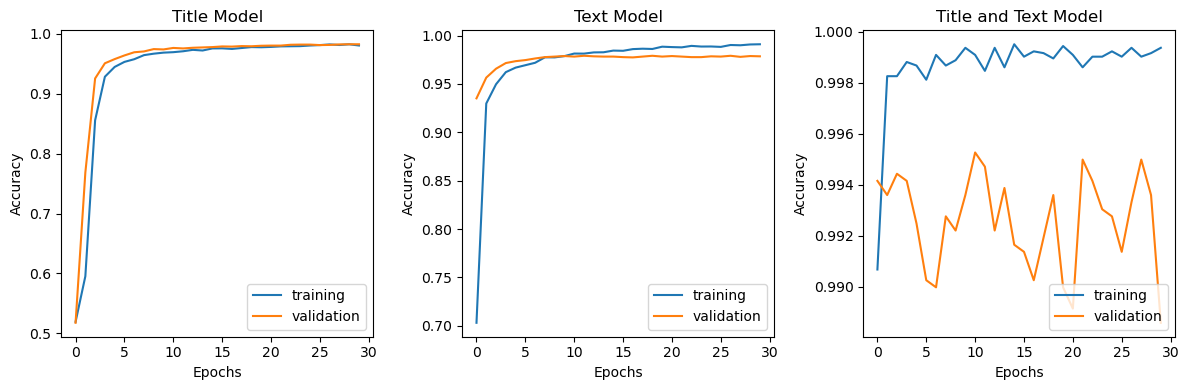

In [15]:
# Create graphs to show training and validation accuracy for each of the 3 models

fig, ax = plt.subplots(1, 3, sharey = False, figsize = (12, 4))

ax[0].plot(history_title.history["accuracy"], label = "training")
ax[1].plot(history_text.history["accuracy"], label = "training")
ax[2].plot(history_both.history["accuracy"], label = "training")

ax[0].plot(history_title.history["val_accuracy"], label = "validation")
ax[1].plot(history_text.history["val_accuracy"], label = "validation")
ax[2].plot(history_both.history["val_accuracy"], label = "validation")

ax[0].set_title('Title Model')
ax[1].set_title('Text Model')
ax[2].set_title('Title and Text Model')

ax[0].set(xlabel = 'Epochs', ylabel = 'Accuracy')
ax[1].set(xlabel = 'Epochs', ylabel = 'Accuracy')
ax[2].set(xlabel = 'Epochs', ylabel = 'Accuracy')

ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower right')
ax[2].legend(loc = 'lower right')

fig.tight_layout()

### What Accuracy Should You Aim For?

Your three different models might have noticeably different performance. Your best model should be able to consistently score at least 97% validation accuracy.

After comparing the performance of each model on validation data, make a recommendation regarding the question at the beginning of this section. Should algorithms use the title, the text, or both when seeking to detect fake news?

Overall all 3 models give excellent results on the validation data (all 3 models consistently give >95% validation accuracy). However, the best model out of all 3 is the model that uses both the title and text values to seek fake news. For this model, the validation accuracy was well above 98% for each epoch. One possible reason is that both the ttitle and text together may provide more details or patterns for the model to detect rather than each one separately.

## Model Evaluation

Now we’ll test your model performance on unseen test data. For this part, you can focus on your best model, and ignore the other two.

Once you’re satisfied with your best model’s performance on validation data, download the test data here:

    test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"

In [16]:
# Load test data and convert to tensorflow dataset

test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"

test_data = pd.read_csv(test_url)

test_TFdata = make_dataset(test_data)

In [17]:
# Store predictions after running best model on test data

predictions = model_both.predict(test_TFdata)

predictions = predictions.argmax(axis = 1)

22449/22449 [==============================] - 14s 614us/step


In [18]:
# Report test accuracy

acc = sum(predictions == test_data['fake']) / len(test_data)

print(f'The test accuracy is{acc * 100: .2f}%')

The test accuracy is 98.98%


# Grading items:


#### Data Prep
1. Stopwords are removed during the construction of the data set.

2. make_dataset is implemented as a function, and used to create both the training/validation and testing data sets.

3. The constructed Dataset has multiple inputs.

4. Write a function to do train test split. 

5. 20% of the training data is split off for validation.

#### Models
6. Model 1 uses only the article title.

7. Model 2 uses only the article text.

8. Model 3 uses both the article title and text.

9. For model 3, embedding is consistent with the text vectorization method. i.e., if you use shared embedding layer, the preceding text vectorization layer also should be shared.

10. The training history is plotted for each of the three models, including the training and validation performance.

11. The most performant model is evaluated on the test data set.

12. The best model consistently obtains at least 97% accuracy on the validation set.

13. The best model’s performance on the test set is shown.

#### Style and Documentation

14. Throughout the HW, function docstrings, incline comments, and markdown are required. 